# Nested sampling with Dynesty

## Time to get your hands dirty.  The transient Universe


Let's go back to our previous example on the astrophysical transient.


8) Fit the same model from before with the same priors,  but this time use nested sampling.

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors (I used `ppf` from `scipy.stats.uniform`, but there are other ways to do it)

An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did earlier.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

Fit this model usign nested sampling and reasonable priors (this time is up to you to decide...)

9) Unlike MCMCs, nested sampling provides the Bayesian evidence. Compute the Bayesian evidence for this Gaussian model, and for the original burst model. Which model is the favored description of the data?

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import emcee as mc
import scipy.stats as sp
import corner
from IPython.display import display, Math
import dynesty
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

First thing to do, load and plot the data

(100, 3)


Text(0.5, 0, 'Time')

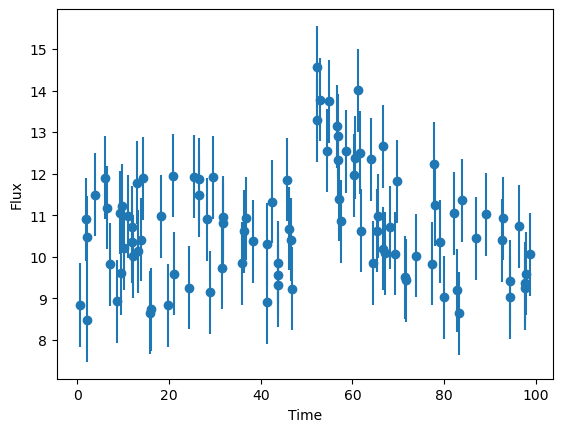

In [2]:
data = np.load('transient.npy')
print(np.shape(data))

plt.errorbar(data[:,0], data[:,1], data[:,2], ls = 'None', marker = 'o')
plt.ylabel('Flux')
plt.xlabel('Time')

## Nested Sampling

Write the priors and the likelihood for the nested sampling:


I assume gaussian error distribution, the likelihood will be the product of
gaussians with the model 'Burst' instead of mu.

In this analysis the priors must be correctly normalized they are just the transformation needed to map the 3D unitary cube values to the 1D interval we need, we can use infact the ppf (inverse of the cumulative) to get the values of the variables from a 0-1 extraction. I initialize it manually in this case.

In [3]:
to_min, to_max = 0, 100
A_min, A_max = 0, 50
b_min, b_max = 0, 50
alpha_min, alpha_max = np.exp(-5), np.exp(5)
sigma_w_min, sigma_w_max = 0, 2

# normalization of the likelihood
lnorm = -0.5 * (np.log(2 * np.pi) + 2 * np.log(data[0,2]))

In [4]:
# Model function
def Burst (time, param):
    
    A, b, to, alpha = param
    model_f = np.zeros(len(time))
    
    for i in range(len(time)):
        
        if time[i] >= to:
            
            model_f[i] = b + A * np.exp(- alpha *(time[i] - to))
            
        else: model_f[i] = b

    return model_f

def Burst_2 (time, param):
    
    A, b, to, sigma_w = param
    return b + A * np.exp(-((time - to)**2)/(2 * sigma_w**2 ))


def Log_Likelihood (param, time, flux, sigma):
     
    # Here I can take directly the log: less computations
    log_L_i = (flux - Burst(time, param))**2 / (sigma**2)
    return -0.5 * np.sum(log_L_i) + lnorm

def Log_Likelihood_2 (param, time, flux, sigma):
     
    # Here I can take directly the log: less computations
    log_L_i = (flux - Burst_2(time, param))**2 / (sigma**2)
    return -0.5 * np.sum(log_L_i) + lnorm

def transform_prior (u):
    
    x = np.copy(u)
    
    x[0] = (A_max - A_min) * u[0] + A_min
    x[1] = (b_max - b_min) * u[1] + b_min
    x[2] = (to_max - to_min) * u[2] + to_min
    x[3] = sp.loguniform.ppf(u[3], alpha_min, alpha_max)

    return x

# Gaussian model priors
def transform_prior_2 (u):
    
    x = np.copy(u)
    
    x[0] = (A_max - A_min) * u[0] + A_min
    x[1] = (b_max - b_min) * u[1] + b_min
    x[2] = (to_max - to_min) * u[2] + to_min
    x[3] = sp.loguniform.ppf(u[3], np.exp(sigma_w_min), np.exp(sigma_w_max))
    
    return x

Plot some 'handmade' paramters

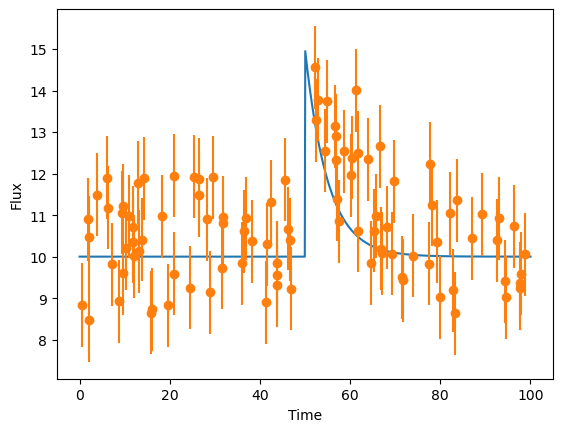

In [5]:
t_grid = np.linspace(0, 100, 1000)
try_param = [5, 10, 50, 0.2]
plt.plot(t_grid, Burst(t_grid, try_param))
plt.errorbar(data[:,0], data[:,1], data[:,2], ls = 'None', marker = 'o')
plt.ylabel('Flux')
plt.xlabel('Time')
plt.show()

Here I run the nested sampling for the Burst model.

dlogz is evaluating how much I gain in evidence step by step, I can fix a treshold; This is the lowest possible error on the evidence

In [6]:
ndim = 4 # Number of paramters

# nested sampling for the transient model with the exponential drop 
sampler = dynesty.NestedSampler(Log_Likelihood, transform_prior, ndim, logl_args = [data[:,0], data[:,1], data[:,2]])
sampler.run_nested(print_progress = True)
sresults_1 = sampler.results
sresults_1.summary()


3535it [00:06, 164.37it/s, bound: 32 | nc: 46 | ncall: 41977 | eff(%):  8.421 | loglstar:   -inf < -88.091 <    inf | logz: -94.719 +/-  0.109 | dlogz: 36.923 >  0.509]    /Users/federicofantoccoli/anaconda3/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
4038it [00:12, 41.56it/s, bound: 68 | nc: 118 | ncall: 69390 | eff(%):  5.819 | loglstar:   -inf < -87.458 <    inf | logz: -94.343 +/-  0.108 | dlogz: 35.541 >  0.509] /Users/federicofantoccoli/anaconda3/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bo

Summary
nlive: 500
niter: 7815
ncall: 116892
eff(%):  7.113
logz: -64.530 +/-  0.302


Peculiar plots format for the nested sampling results: they are weighted, they need to be plotted properly with dynesty fucntions.
They are mostly diagnostic plots: -lnX is the log of the prior volume: from left to right I'm climbing the likelihood and redcucing the prior volume I explore

It's possible to do the plots with other libraries, but it's necessary to make the sample weights all equal; this can be done in the way I show at the bottom. In the next exercises I tried Nested sampling plot with other libraries

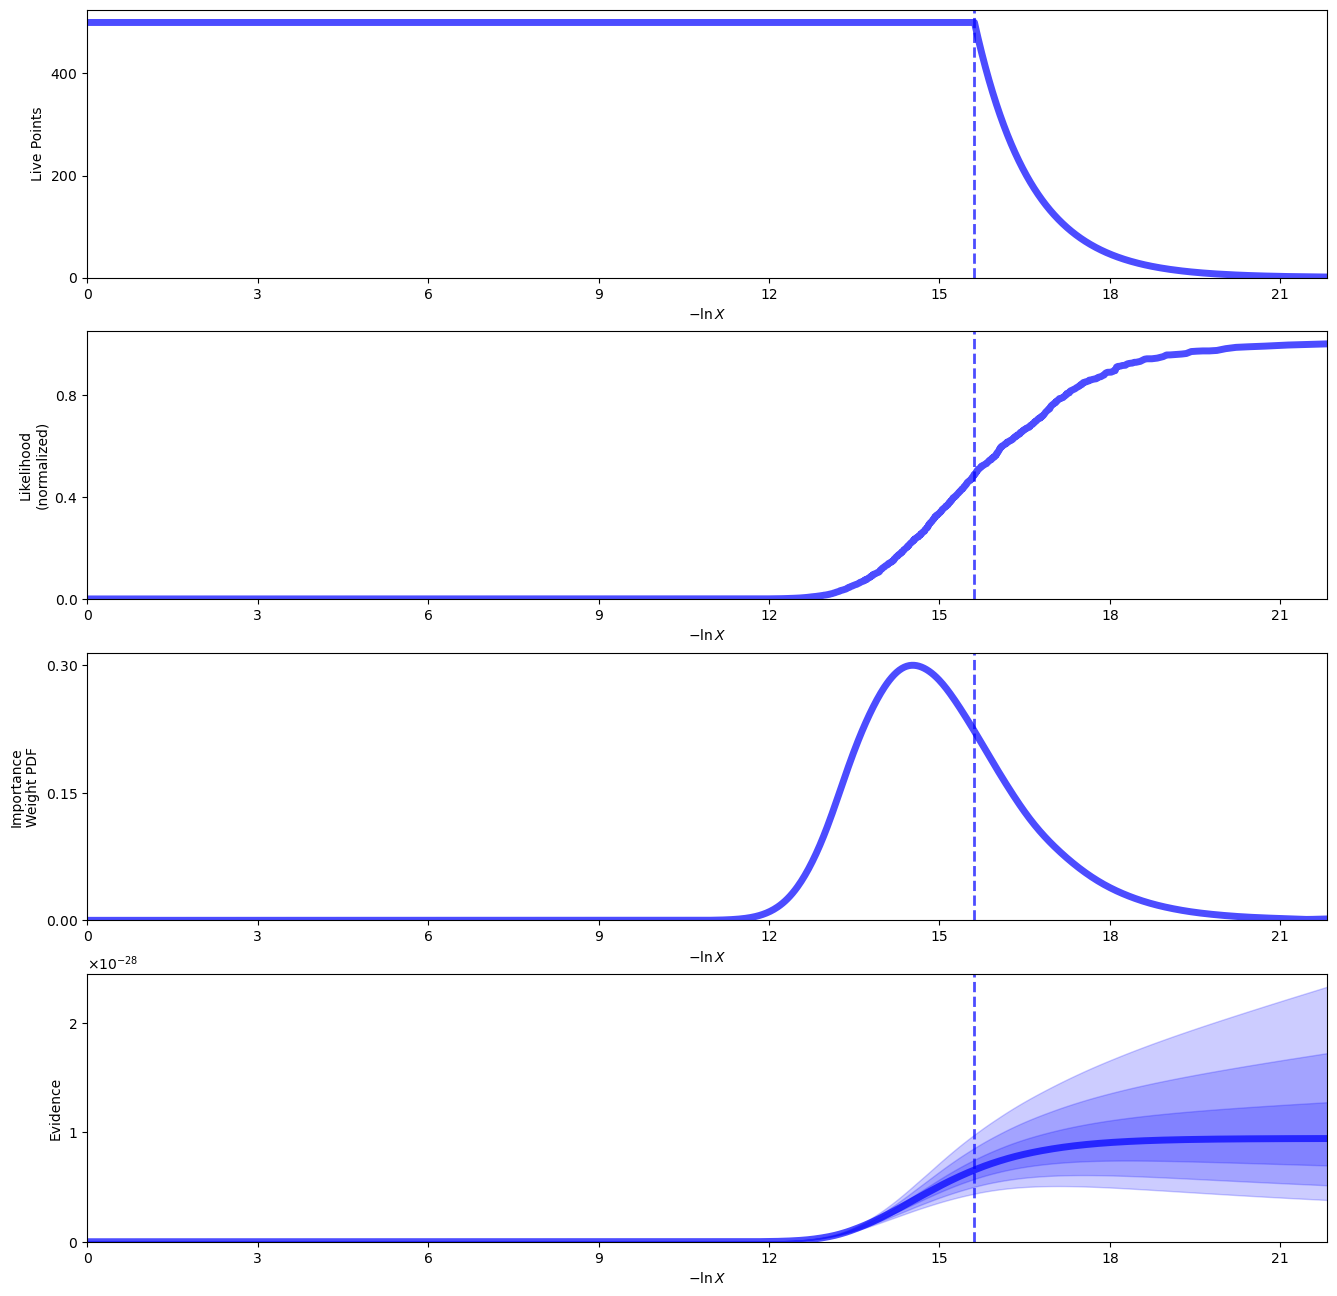

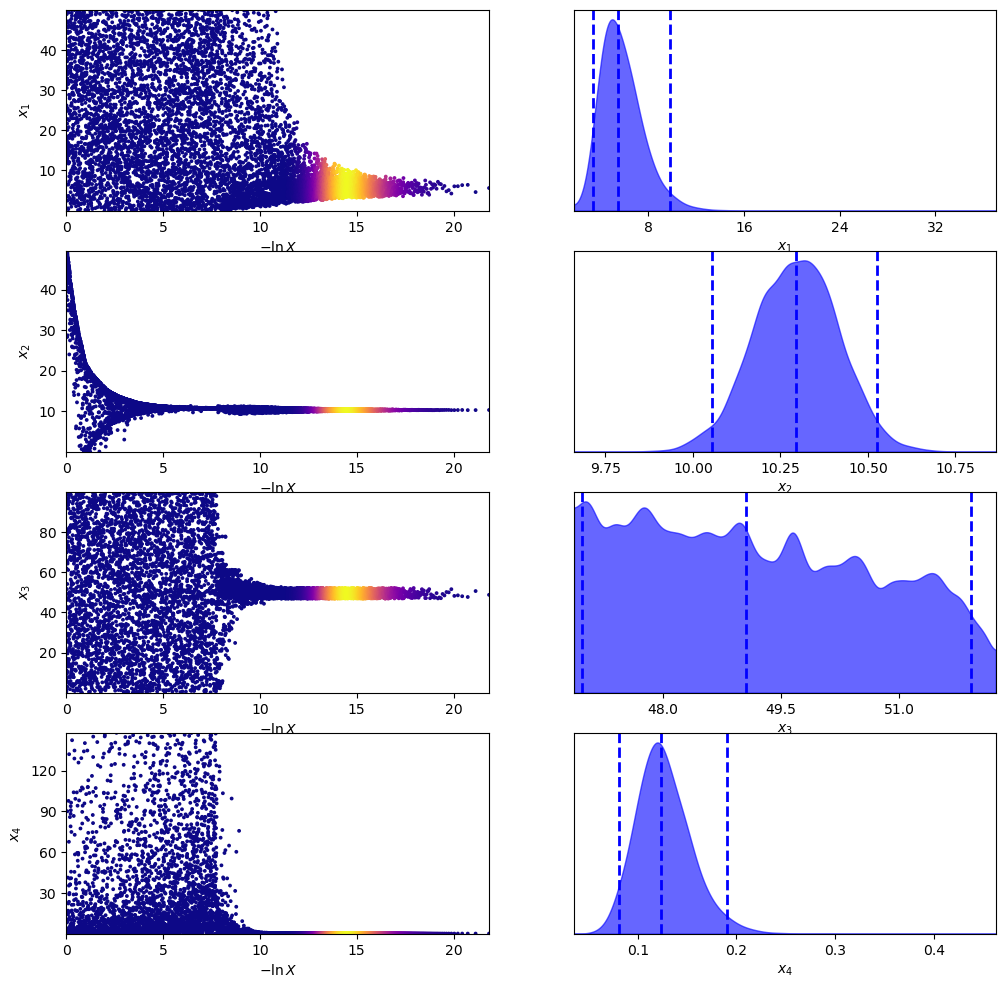

In [7]:
rfig, raxes = dyplot.runplot(sresults_1)
tfig, taxes = dyplot.traceplot(sresults_1)

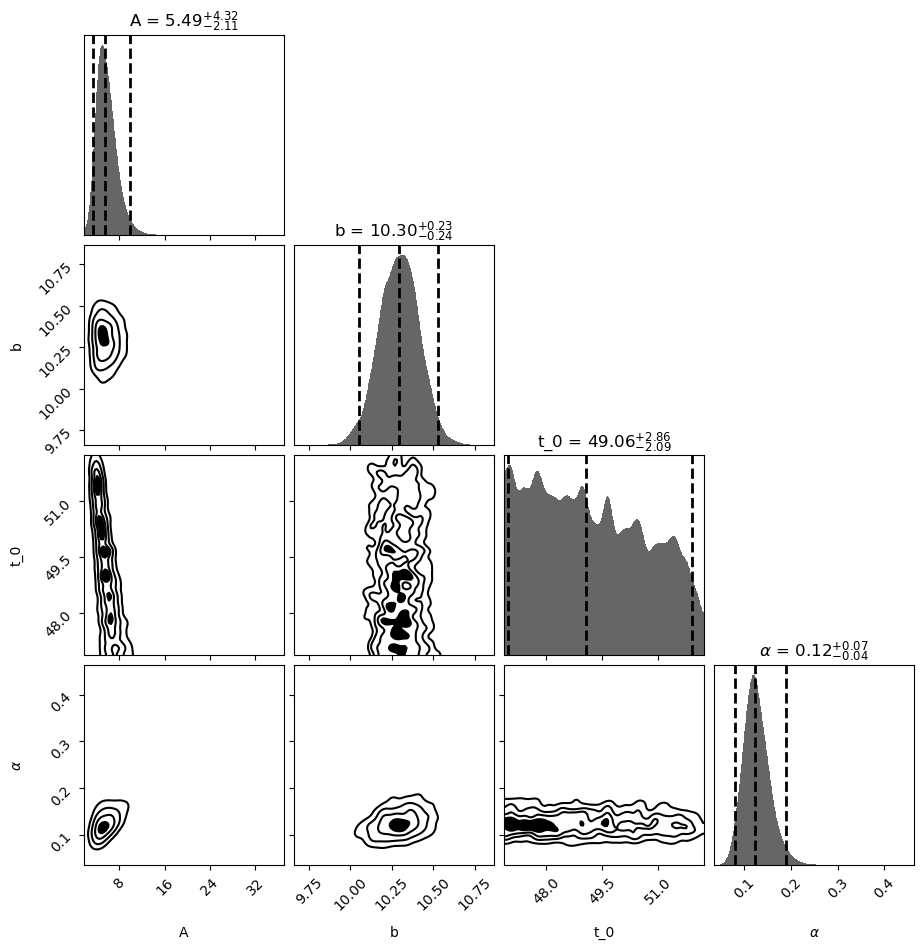

In [8]:
Burst_labels = ['A', 'b', 't_0', r'$\alpha$']
cfig, caxes = dyplot.cornerplot(sresults_1, labels = Burst_labels, show_titles=True)

Here I run the nested sampling with the Gaussian model

In [9]:
ndim = 4 # Number of parameters

# nested sampling for gaussian burst.
sampler = dynesty.NestedSampler(Log_Likelihood_2, transform_prior_2, ndim, logl_args = [data[:,0], data[:,1], data[:,2]])
sampler.run_nested(print_progress = True)
sresults_2 = sampler.results
sresults_2.summary()

3687it [00:06, 300.10it/s, bound: 35 | nc: 115 | ncall: 43152 | eff(%):  8.544 | loglstar:   -inf < -92.133 <    inf | logz: -101.479 +/-  0.130 | dlogz: 37.999 >  0.509]   /Users/federicofantoccoli/anaconda3/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from bootstrapping is very large. If you are using uniform sampling that may mean that the sampling will be inefficient. This may be caused by a very complex posterior shape. You may consider using more livepoints or different sampler (i.e. rslice or rwalk) or alternatively disable bootstrap (bootstrap=0)
  warnings.warn(
3927it [00:07, 180.34it/s, bound: 45 | nc: 34 | ncall: 51045 | eff(%):  7.693 | loglstar:   -inf < -88.313 <    inf | logz: -98.079 +/-  0.131 | dlogz: 34.129 >  0.509]  /Users/federicofantoccoli/anaconda3/lib/python3.12/site-packages/dynesty/bounding.py:617: UserWarning: The enlargement factor for the ellipsoidal bounds determined from 

Summary
nlive: 500
niter: 7689
ncall: 100352
eff(%):  8.160
logz: -68.014 +/-  0.295


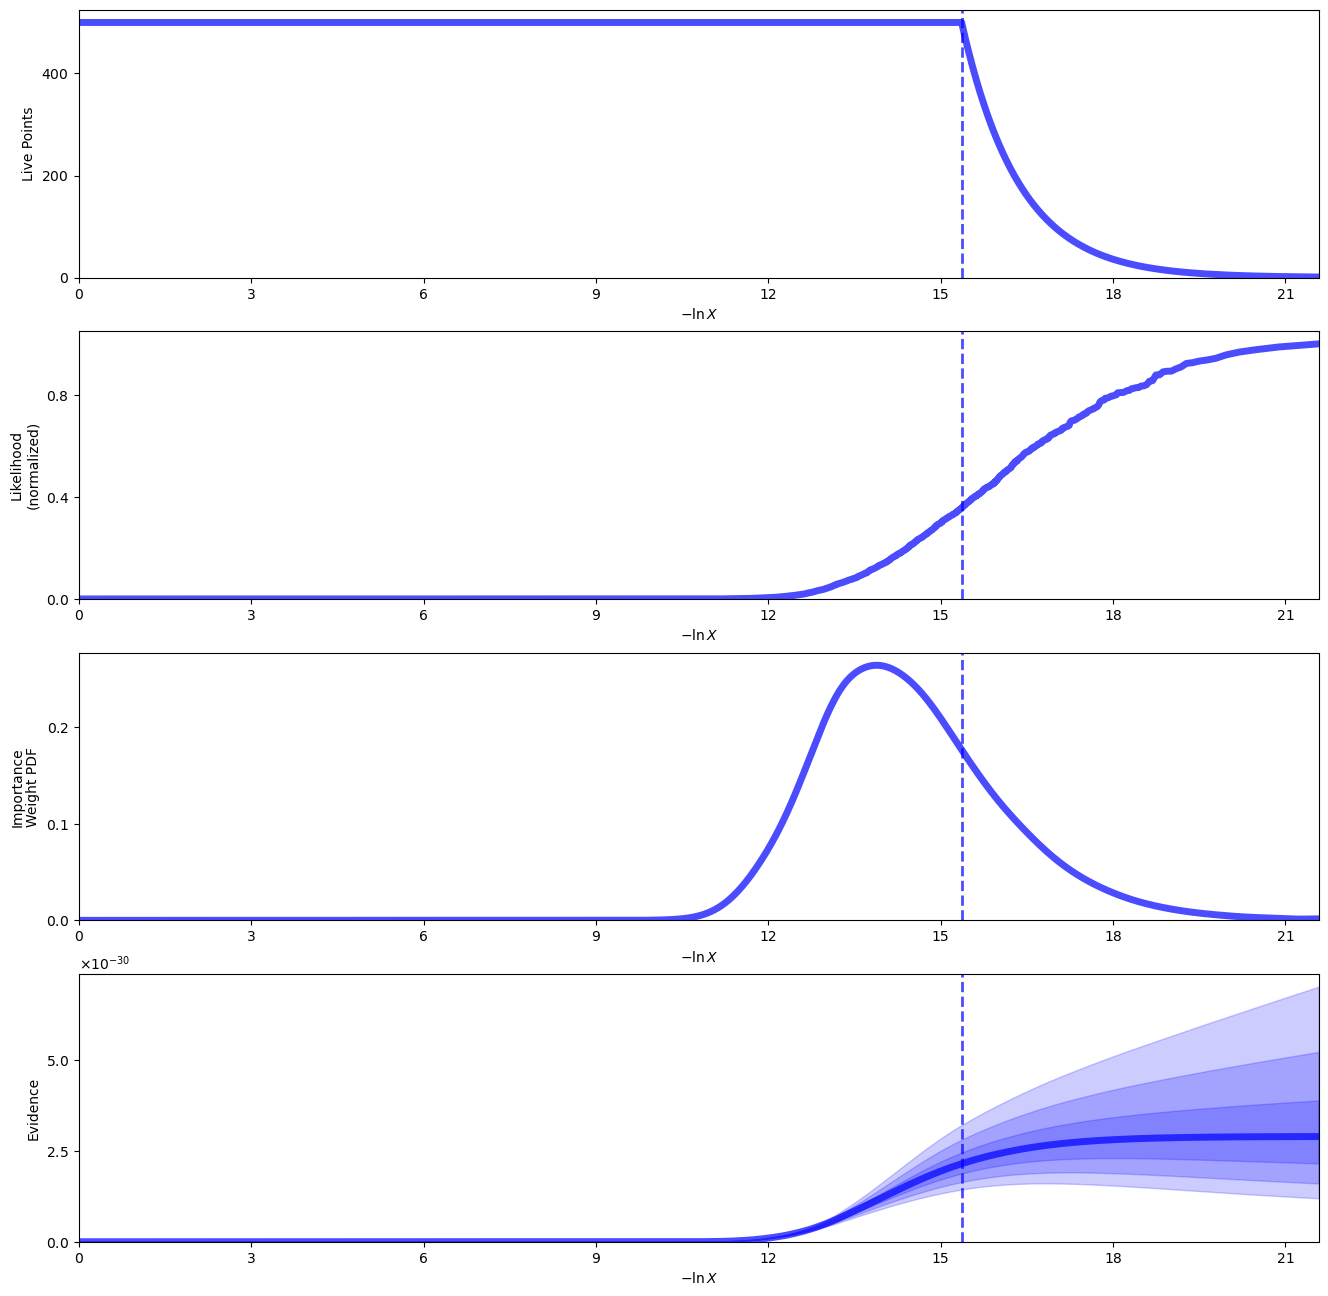

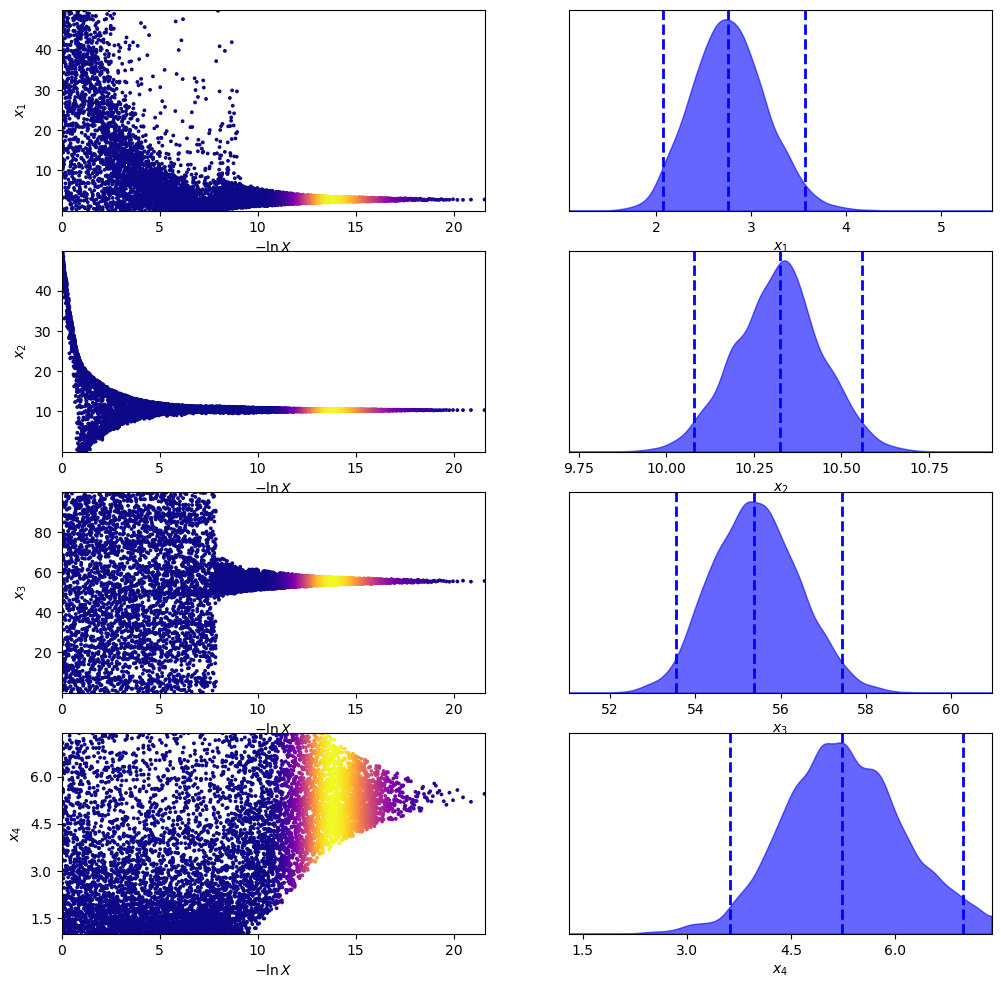

In [11]:
rfig, raxes = dyplot.runplot(sresults_2)
tfig, taxes = dyplot.traceplot(sresults_2)

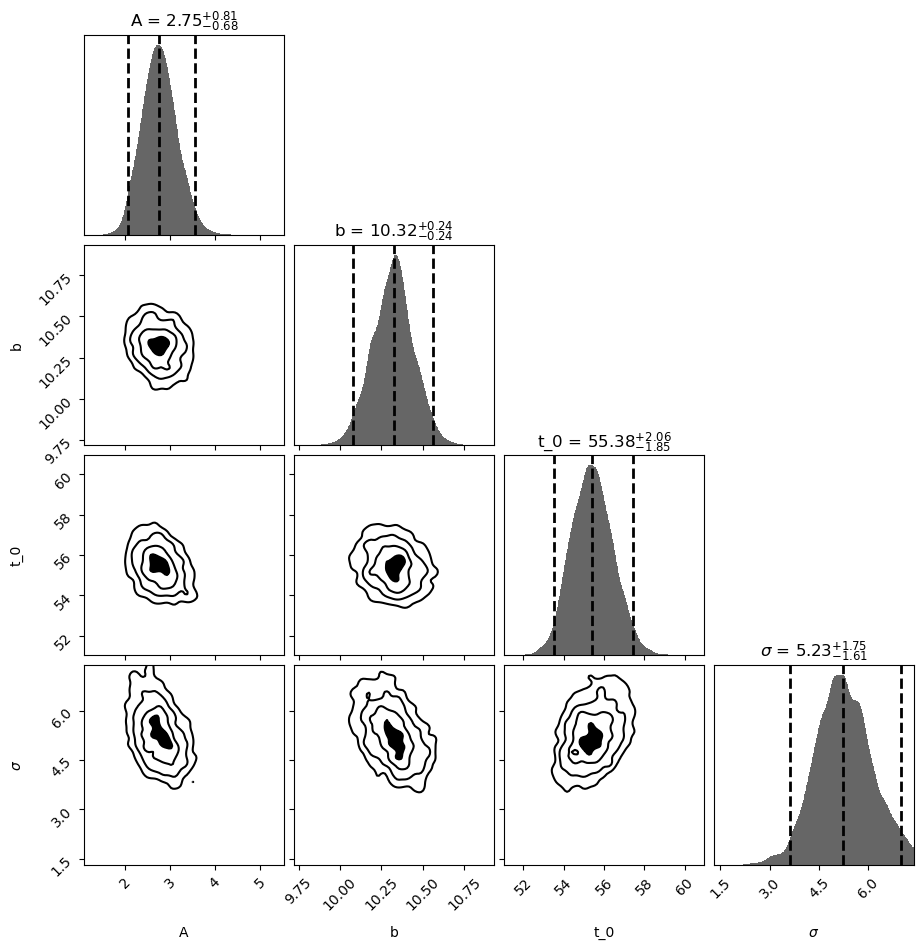

In [12]:
Gauss_labels = ['A', 'b', 't_0', r'$\sigma$']
cfig, caxes = dyplot.cornerplot(sresults_2, labels = Gauss_labels, show_titles=True)

## Model Comparison

In [13]:
# Comparison

Burst_evidence = np.exp(sresults_1['logz'][-1])
print('Burst evidence: ', Burst_evidence)

Gauss_evidence = np.exp(sresults_2['logz'][-1])
print('Gauss Burst evidence: ', Gauss_evidence )

print('Bayes factor (Burst / Gauss) = ', Burst_evidence / Gauss_evidence)
print('Logaritmic Bayes factor = ', np.log(Burst_evidence / Gauss_evidence))

Burst evidence:  9.444126214773846e-29
Gauss Burst evidence:  2.8979109508402184e-30
Bayes factor (Burst / Gauss) =  32.589428643539314
Logaritmic Bayes factor =  3.483987961046182


The evidence is $\textbf{Very strong}$ in favor of the Burst model


Plot some random samples from both models to compare them visually

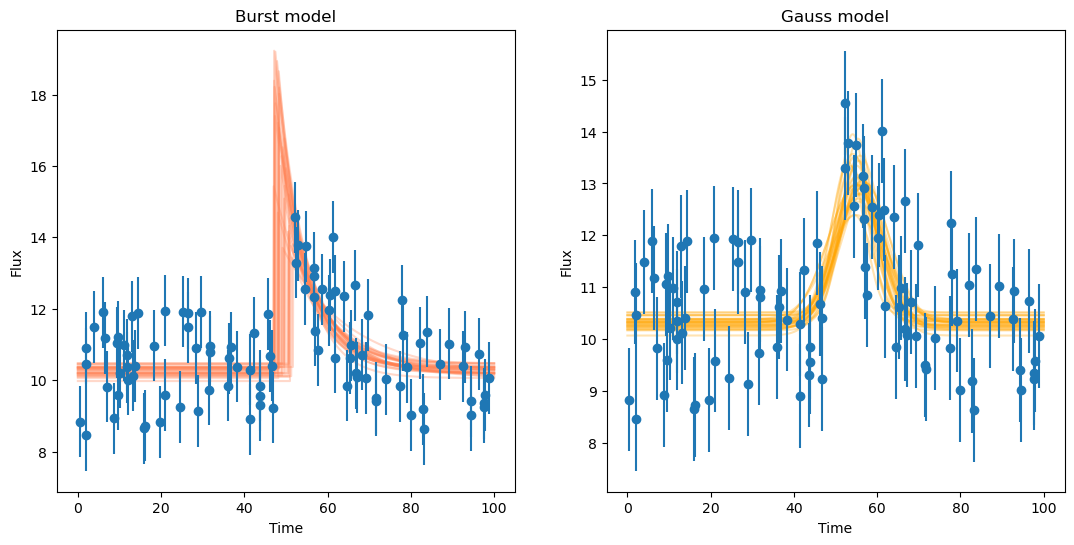

In [14]:
samples_1 = sresults_1.samples  # samples
weights_1 = np.exp(sresults_1.logwt - sresults_1.logz[-1])  # normalized weights

# make the data all with the same weights
samples_equal_1 = dyfunc.resample_equal(samples_1, weights_1)

samples_2 = sresults_2.samples  # samples
weights_2 = np.exp(sresults_2.logwt - sresults_2.logz[-1])  # normalized weights (look at documentation)

# make the data all with the same weights
samples_equal_2 = dyfunc.resample_equal(samples_2, weights_2)

time_grid=np.linspace(0,100,100)
fig = plt.figure(figsize = (13, 6))

# Burst model
chosen_samples_1 = samples_equal_1[np.random.choice(len(samples_equal_1), size=30)]

ax = fig.add_subplot(121)
for chosen_theta in chosen_samples_1:

    y_grid =  Burst(t_grid, chosen_theta)
    ax.plot(t_grid, y_grid, alpha = 0.3, c = 'coral')

ax.errorbar(data[:,0], data[:,1], data[:,2], ls = 'None', marker = 'o')
plt.title('Burst model')
plt.ylabel('Flux')
plt.xlabel('Time')

# Gauss model
chosen_samples_2 = samples_equal_2[np.random.choice(len(samples_equal_2), size=30)]

ax = fig.add_subplot(122)
for chosen_theta in chosen_samples_2:

    y_grid =  Burst_2(t_grid, chosen_theta)
    ax.plot(t_grid, y_grid, alpha = 0.3, c = 'orange')
    
ax.errorbar(data[:,0], data[:,1], data[:,2], ls = 'None', marker = 'o')
plt.title('Gauss model')
plt.ylabel('Flux')
plt.xlabel('Time')
plt.show()